In [1]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("tqdm version: {}".format(tq.__version__))
print("sktime version: {}".format(sktime.__version__))
print("xgboost version: {}".format(xgb.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(skl.__version__))
print("------------------------------------------------------------------------------")

-------------------------- Python & library version --------------------------
Python version: 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.5.3
numpy version: 1.24.3
matplotlib version: 3.7.1
tqdm version: 4.65.0
sktime version: 0.18.1
xgboost version: 1.7.5
seaborn version: 0.12.2
scikit-learn version: 1.2.2
------------------------------------------------------------------------------


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import GridSearchCV
import time
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

In [3]:
train = pd.read_excel('Train_dataset.xlsx')
answer = pd.read_excel('Answer_sheet.xlsx')
weather = pd.read_csv('weather.csv', encoding='CP949')

train = pd.concat([train, answer], axis=0)

weather.rename(columns={"일시": "Time", "기온(°C)":"Temp", "풍속(m/s)": "WS", "습도(%)":"HMD", "일조(hr)": "Sun", "강수량(mm)": "prec"}, inplace=True)
weather['HMD'] = weather['HMD'].interpolate(method='linear')
weather['Temp'] = weather['Temp'].interpolate(method='linear')
weather = weather[['Time', "Temp", "HMD", "WS", "Sun", "prec"]]

weather['Time'] = pd.to_datetime(weather['Time'], format='%Y-%m-%d %H:%M')
train['Time'] = pd.to_datetime(train['Time'], format='%Y%m%d_%H')
answer['Time'] = pd.to_datetime(answer['Time'], format='%Y%m%d_%H')

weather = weather.fillna(0)

train = train.sort_values(by='Time')

train = pd.merge(train, weather, on='Time', how='inner')
answer = pd.merge(answer, weather, on='Time', how='inner')

In [4]:
def make_time(data):
    cols = ['date_time', 'power', 'temp', 'hum', 'wind','sun', 'prec']
    data.columns = cols
    # 시간 관련 변수들 생성
    date = pd.to_datetime(data.date_time)
    data['hour'] = date.dt.hour
    data['day'] = date.dt.weekday
    data['month'] = date.dt.month
    data['week'] = date.dt.weekofyear

In [5]:
def remove_outlier(d_cp, column):
    fraud_column_data = d_cp[column]
    quan_25 = np.percentile(fraud_column_data.values, 25)
    quan_75 = np.percentile(fraud_column_data.values, 75)

    iqr = quan_75 - quan_25
    iqr_weight = iqr * 1.5
    lowest = quan_25 - iqr_weight
    highest = quan_75 + iqr_weight

    outlier_index = fraud_column_data[(fraud_column_data < lowest) | (fraud_column_data > highest)].index
    d_cp.drop(outlier_index, axis=0, inplace=True)
    return d_cp

In [6]:
def replace_outlier_with_zero(d_cp, column):
    fraud_column_data = d_cp[column]
    quan_25 = np.percentile(fraud_column_data.values, 25)
    quan_75 = np.percentile(fraud_column_data.values, 75)

    iqr = quan_75 - quan_25
    iqr_weight = iqr * 1.5
    lowest = quan_25 - iqr_weight
    highest = quan_75 + iqr_weight

    outlier_index = fraud_column_data[(fraud_column_data < lowest) | (fraud_column_data > highest)].index
    d_cp.loc[outlier_index, column] = 0
    return d_cp

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8736 entries, 0 to 8735
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    8736 non-null   datetime64[ns]
 1   Power   7863 non-null   float64       
 2   Temp    8736 non-null   float64       
 3   HMD     8736 non-null   float64       
 4   WS      8736 non-null   float64       
 5   Sun     8736 non-null   float64       
 6   prec    8736 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 546.0 KB


In [8]:
train = train.dropna()
train = train[train['Power'] != 0]
train = remove_outlier(train,'Power')

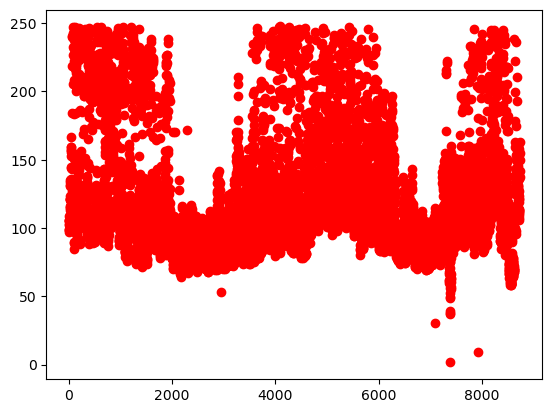

In [9]:
plt.plot(train['Power'], 'ro')

In [10]:
# train = replace_outlier_with_zero(train,'Power')
# train['Power'] = train['Power'].replace(0, np.nan)
# train['Power'] = train['Power'].interpolate(method='linear')

In [11]:
## 변수들을 영문명으로 변경
cols = ['date_time', 'power', 'temp', 'hum', 'wind','sun', 'prec']
train.columns = cols

# 시간 관련 변수들 생성
date = pd.to_datetime(train.date_time)
train['hour'] = date.dt.hour
train['day'] = date.dt.weekday
train['month'] = date.dt.month
train['week'] = date.dt.weekofyear

hour_mean = train.groupby(train['hour'])['power'].mean()
train['hour_mean'] = train['hour'].map(hour_mean)

# day_mean = train.groupby(train['day'])['power'].mean()
# train['day_mean'] = train['day'].map(day_mean)

# week_mean = train.groupby(train['week'])['power'].mean()
# train['week_mean'] = train['week'].map(week_mean)

# month_mean = train.groupby(train['month'])['power'].mean()
# train['month_mean'] = train['month'].map(month_mean)

### 공휴일 변수 추가
train['holiday'] = train.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
train['THI'] = 9/5*train['temp'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7237 entries, 0 to 8735
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  7237 non-null   datetime64[ns]
 1   power      7237 non-null   float64       
 2   temp       7237 non-null   float64       
 3   hum        7237 non-null   float64       
 4   wind       7237 non-null   float64       
 5   sun        7237 non-null   float64       
 6   prec       7237 non-null   float64       
 7   hour       7237 non-null   int64         
 8   day        7237 non-null   int64         
 9   month      7237 non-null   int64         
 10  week       7237 non-null   int64         
 11  hour_mean  7237 non-null   float64       
 12  holiday    7237 non-null   int64         
 13  sin_time   7237 non-null   float64       
 14  cos_time   7237 non-null   float64       
 15  THI        7237 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(5

C:\Users\sunghyun\AppData\Local\Temp\ipykernel_5804\4050398092.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['week'] = date.dt.weekofyear


In [12]:
## 변수들을 영문명으로 변경
cols = ['date_time', 'temp', 'hum', 'wind', 'sun', 'prec']
answer.columns = cols

# 시간 관련 변수들 생성
date = pd.to_datetime(answer.date_time)
answer['hour'] = date.dt.hour
answer['day'] = date.dt.weekday
answer['month'] = date.dt.month
answer['week'] = date.dt.weekofyear

# answer['hour_mean'] = answer['hour'].map(hour_mean)
# answer['day_mean'] = answer['day'].map(day_mean)
# answer['week_mean'] = answer['week'].map(week_mean)
# answer['month_mean'] = answer['month'].map(month_mean)

### 공휴일 변수 추가
answer['holiday'] = answer.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
answer['sin_time'] = np.sin(2*np.pi*answer.hour/24)
answer['cos_time'] = np.cos(2*np.pi*answer.hour/24)

## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
answer['THI'] = 9/5*answer['temp'] - 0.55*(1-answer['hum']/100)*(9/5*answer['hum']-26)+32

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

answer.drop(['hour', 'date_time'], axis = 1, inplace = True)
train.drop(['hour', 'date_time'], axis = 1, inplace = True)
answer.head()
answer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873 entries, 0 to 872
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      873 non-null    float64
 1   hum       873 non-null    float64
 2   wind      873 non-null    float64
 3   sun       873 non-null    float64
 4   prec      873 non-null    float64
 5   day       873 non-null    int64  
 6   month     873 non-null    int64  
 7   week      873 non-null    int64  
 8   holiday   873 non-null    int64  
 9   sin_time  873 non-null    float64
 10  cos_time  873 non-null    float64
 11  THI       873 non-null    float64
dtypes: float64(8), int64(4)
memory usage: 88.7 KB


C:\Users\sunghyun\AppData\Local\Temp\ipykernel_5804\3462415696.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  answer['week'] = date.dt.weekofyear


In [13]:
## 7번 건물의 발전량
from sklearn.model_selection import train_test_split
features = ['temp', 'hum', 'wind', 'sun', 'prec', 'day', 'month', 'week', 
            'holiday', 'sin_time', 'cos_time', 'THI']
# ''hour_mean', 'day_mean', 'week_mean', 'month_mean', 

df = train

X2 = train[features]
Y2 = train['power']

train, test = train_test_split(df, test_size=0.1)
# test = train[-279:]


X_train = train[features]
Y_train = train['power']

X_test = test[features]
y_test = test['power']

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(y_test.shape)

# plot_series(y_train, y_test, markers=[',' , ','])
# plt.show()

(6513, 12)
(6513,)
(724, 12)
(724,)


In [14]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7237 entries, 0 to 8735
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      7237 non-null   float64
 1   hum       7237 non-null   float64
 2   wind      7237 non-null   float64
 3   sun       7237 non-null   float64
 4   prec      7237 non-null   float64
 5   day       7237 non-null   int64  
 6   month     7237 non-null   int64  
 7   week      7237 non-null   int64  
 8   holiday   7237 non-null   int64  
 9   sin_time  7237 non-null   float64
 10  cos_time  7237 non-null   float64
 11  THI       7237 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 735.0 KB


In [15]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [16]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [17]:
## Various hyper-parameters to tune

start_time = time.time()
xgb1 = XGBRegressor(tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')
parameters = {'objective':['reg:squarederror'],
              'eval_metric':['rmse'],
              'gamma':[0, 1, 3, 5],
              'min_child_weight': [1, 3, 5, 7],
              'max_depth': [2, 4, 6, 8],
              'n_estimators': [30, 50, 100, 150],
              'learning_rate': [0.1, 0.3, 0.5]
             }
#
# 'n_estimators': [30, 50, 100]
#               'max_depth': [4, 6, 8, 10],
#               'min_child_weight': [3, 5, 7],
#               'n_estimators': [30, 50, 100, 200],
# 'learning_rate': [0.2, 0.5, 1]

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=2)
 

xgb_grid.fit(X2, Y2)

end_time = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print(f'소요시간: {(end_time - start_time)} 초')

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def calRmse(p, a):
    rmse = sqrt(mean_squared_error(p, a))
    return rmse

In [19]:
best_params = xgb_grid.best_params_

xgb = XGBRegressor(**best_params, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')

xgb.fit(X_train, Y_train)

ypred1 = xgb.predict(X_test)

print(calRmse(ypred1, y_test))

15.784696982793363


In [20]:
xgb2 = XGBRegressor(tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')

xgb2.fit(X_train, Y_train)

ypred2 = xgb2.predict(X_test)

print(calRmse(ypred2, y_test))

16.77425279342818


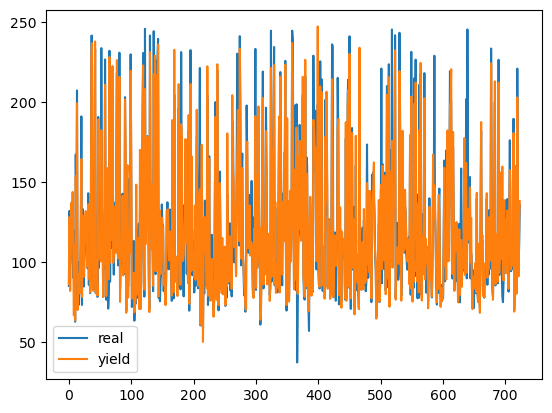

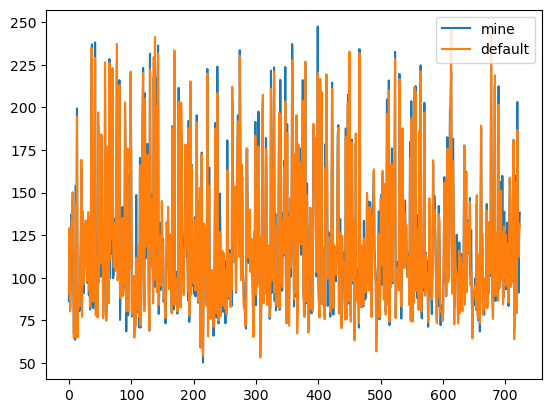

In [21]:
x1 = range(len(ypred1))

plt.plot(x1, y_test)
plt.plot(x1, ypred1)
plt.legend(['real', 'yield'])
plt.show()

plt.plot(x1, ypred1)
plt.plot(x1, ypred2)
plt.legend(['mine', 'default'])
plt.show()

In [22]:
# # tempg = xgb_grid_best_params_
# train = pd.read_excel('Train_dataset.xlsx')

# train['Time'] = pd.to_datetime(train['Time'], format='%Y%m%d_%H')

# train = pd.merge(train, weather, on='Time', how='inner')


# ## 변수들을 영문명으로 변경
# cols = ['date_time', 'power', 'temp', 'hum', 'wind', 'sun', 'prec']
# train.columns = cols

# # 시간 관련 변수들 생성
# date = pd.to_datetime(train.date_time)
# train['hour'] = date.dt.hour
# train['day'] = date.dt.weekday
# train['month'] = date.dt.month
# train['week'] = date.dt.weekofyear

# # hour_mean = train.groupby(train['hour'])['power'].mean()
# # train['hour_mean'] = train['hour'].map(hour_mean)

# # day_mean = train.groupby(train['day'])['power'].mean()
# # train['day_mean'] = train['day'].map(day_mean)

# # week_mean = train.groupby(train['week'])['power'].mean()
# # train['week_mean'] = train['week'].map(week_mean)

# # month_mean = train.groupby(train['month'])['power'].mean()
# # train['month_mean'] = train['month'].map(month_mean)

# ### 공휴일 변수 추가
# train['holiday'] = train.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

# ## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
# train['sin_time'] = np.sin(2*np.pi*train.hour/24)
# train['cos_time'] = np.cos(2*np.pi*train.hour/24)

# ## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
# train['THI'] = 9/5*train['temp'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32

# def CDH(xs):
#     ys = []
#     for i in range(len(xs)):
#         if i < 11:
#             ys.append(np.sum(xs[:(i+1)]-26))
#         else:
#             ys.append(np.sum(xs[(i-11):(i+1)]-26))
#     return np.array(ys)

# train.drop(['hour','date_time'], axis = 1, inplace = True)
# train.head()

In [23]:
# features = ['temp', 'hum', 'wind', 'sun', 'prec', 'day', 'month', 'week', 'hour_mean', 'day_mean', 
#             'week_mean', 'month_mean', 'holiday', 'sin_time', 'cos_time', 'THI']

X = train[features]
y = train['power']

xgb = XGBRegressor(**best_params, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')
# xgb = XGBRegressor(tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')

xgb.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=1, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor='gpu_predictor', random_state=None, ...)

In [24]:
# answer.drop(['date_time'], axis = 1, inplace = True)
answer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873 entries, 0 to 872
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      873 non-null    float64
 1   hum       873 non-null    float64
 2   wind      873 non-null    float64
 3   sun       873 non-null    float64
 4   prec      873 non-null    float64
 5   day       873 non-null    int64  
 6   month     873 non-null    int64  
 7   week      873 non-null    int64  
 8   holiday   873 non-null    int64  
 9   sin_time  873 non-null    float64
 10  cos_time  873 non-null    float64
 11  THI       873 non-null    float64
dtypes: float64(8), int64(4)
memory usage: 88.7 KB


In [25]:
y_pred = xgb.predict(answer)

In [26]:
# y_pred = pd.DataFrame(y_pred)
# y_pred.columns = ["Power"]
# display(y_pred)

# columns_to_inverse_scale = [col for col in answer.columns]
# df_to_inverse_scale = answer[columns_to_inverse_scale]

# display(df_to_inverse_scale)

# # Inverse transform the scaled data
# inverse_scaled_data = scaler.inverse_transform(df_to_inverse_scale)

# # Create a new DataFrame with the inverse scaled data
# inverse_scaled_df = pd.DataFrame(answer, columns=columns_to_inverse_scale)

# # Add the excluded columns back to the inverse scaled DataFrame
# # inverse_scaled_df[exclude_columns] = answer[exclude_columns]

# display(inverse_scaled_df)

In [27]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ["Power"]
display(y_pred)
display(answer)
result = pd.concat([answer, y_pred], axis=1)
display(result)

,Power
0,110.507324
1,135.296310
2,122.544243
3,143.260223
4,89.666985
...,...
868,141.298141
869,119.221283
870,123.823715
871,149.068909


,temp,hum,wind,sun,prec,day,month,week,holiday,sin_time,cos_time,THI
0,4.5,34.0,2.2,1.0,0.0,0,1,1,0,-0.500000,-0.866025,27.3224
1,3.2,47.0,1.1,0.6,0.0,0,1,1,0,-0.965926,-0.258819,20.6781
2,1.0,56.0,0.7,0.0,0.0,0,1,1,0,-0.965926,0.258819,15.6984
3,-2.2,72.0,0.3,0.0,0.0,0,1,1,0,-0.258819,0.965926,12.0856
4,-5.2,82.0,1.1,0.0,0.0,0,1,1,0,0.866025,-0.500000,10.6016
...,...,...,...,...,...,...,...,...,...,...,...,...
868,-0.6,30.0,1.5,1.0,0.0,6,12,52,1,-0.707107,-0.707107,20.1400
869,-5.9,53.0,1.2,0.0,0.0,0,12,1,0,0.000000,1.000000,3.4401
870,0.2,36.0,0.7,1.0,0.0,0,12,1,0,-0.258819,-0.965926,18.7024
871,0.1,33.0,2.9,0.7,0.0,0,12,1,0,-0.965926,-0.258819,19.8721


,temp,hum,wind,sun,prec,day,month,week,holiday,sin_time,cos_time,THI,Power
0,4.5,34.0,2.2,1.0,0.0,0,1,1,0,-0.500000,-0.866025,27.3224,110.507324
1,3.2,47.0,1.1,0.6,0.0,0,1,1,0,-0.965926,-0.258819,20.6781,135.296310
2,1.0,56.0,0.7,0.0,0.0,0,1,1,0,-0.965926,0.258819,15.6984,122.544243
3,-2.2,72.0,0.3,0.0,0.0,0,1,1,0,-0.258819,0.965926,12.0856,143.260223
4,-5.2,82.0,1.1,0.0,0.0,0,1,1,0,0.866025,-0.500000,10.6016,89.666985
...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,-0.6,30.0,1.5,1.0,0.0,6,12,52,1,-0.707107,-0.707107,20.1400,141.298141
869,-5.9,53.0,1.2,0.0,0.0,0,12,1,0,0.000000,1.000000,3.4401,119.221283
870,0.2,36.0,0.7,1.0,0.0,0,12,1,0,-0.258819,-0.965926,18.7024,123.823715
871,0.1,33.0,2.9,0.7,0.0,0,12,1,0,-0.965926,-0.258819,19.8721,149.068909


In [28]:
# exclude_columns = ['Power']
# columns_to_inverse_scale = [col for col in result.columns if col not in exclude_columns]
# df_to_inverse_scale = result[columns_to_inverse_scale]

# print(df_to_inverse_scale)

# # Inverse transform the scaled data
# inverse_scaled_data = scaler.inverse_transform(df_to_inverse_scale)

# # Create a new DataFrame with the inverse scaled data
# inverse_scaled_df = pd.DataFrame(result, columns=columns_to_inverse_scale)

# # Add the excluded columns back to the inverse scaled DataFrame
# inverse_scaled_df[exclude_columns] = result[exclude_columns]

# display(inverse_scaled_df)

In [31]:
real_answer = pd.read_excel('Answer_sheet.xlsx')
real_answer['Time'] = pd.to_datetime(real_answer['Time'], format='%Y%m%d_%H')
real_answer = pd.concat([real_answer, result['Power']], axis=1)
display(real_answer)

,Time,Power
0,2018-01-01 14:00:00,110.507324
1,2018-01-01 17:00:00,135.296310
2,2018-01-01 19:00:00,122.544243
3,2018-01-01 23:00:00,143.260223
4,2018-01-01 08:00:00,89.666985
...,...,...
868,2018-12-30 15:00:00,141.298141
869,2018-12-31 00:00:00,119.221283
870,2018-12-31 13:00:00,123.823715
871,2018-12-31 17:00:00,149.068909


In [32]:
#real_answer.to_excel('predict_18011668_변성현_7주차.xlsx', index=False)

[0.11813384 0.02270266 0.01343467 0.03757671 0.00702203 0.16302153
 0.16949317 0.1608418  0.00470415 0.12322506 0.12644398 0.0534004 ]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

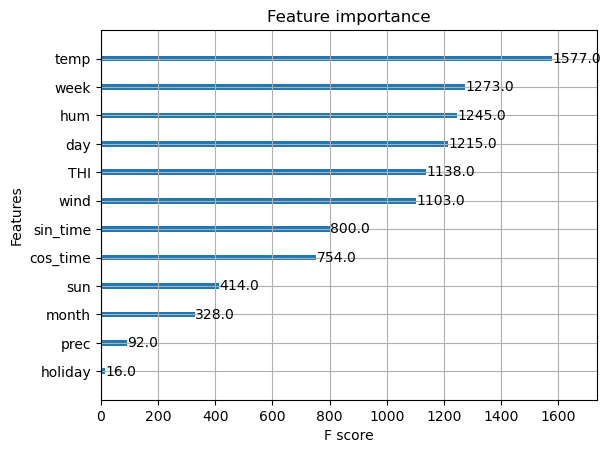

In [34]:
# 특성 중요도 출력
print(xgb.feature_importances_)

# 특성 중요도 시각화
from xgboost import plot_importance
plot_importance(xgb)